# 一、 Policy iteration

In [39]:
import numpy as np

from copy import copy


def policy_eval(env, values, policies, upper_bound):
    # print('\n===== Policy Evalution =====')
    delta = upper_bound
    iteration = 0

    while delta >= upper_bound:
        delta = 0.

        for s in env.states:
            v = values.get(s)
            env.set_state(s)

            action_index = policies.sample(s)
            action = env.actions[action_index]
            _, _, rewards, next_states = env.step(action)

            next_values = values.get(list(next_states))
            td_values = list(map(lambda x, y: x + env.gamma * y, rewards, next_values))

            exp_value = np.mean(td_values)
            values.update(s, exp_value)

            # update delta
            delta = max(delta, abs(v - exp_value))
            
        iteration += 1
    # print('> iteration: {} delta: {}'.format(iteration, delta), flush=True, end="")

In [40]:
def policy_improve(env, values, policies):
    # print('\n===== Policy Improve =====')
    policy_stable = True
    
    for state in env.states:
        old_act = policies.sample(state)

        # calculate new policy execution
        actions = env.actions
        value = [0] * len(env.actions)
        
        for i, action in enumerate(actions):
            env.set_state(state)
            _, _, rewards, next_states = env.step(action)
            next_values = values.get(list(next_states))
            td_values = list(map(lambda x, y: x + env.gamma * y, rewards, next_values))
            prob = [1 / len(next_states)] * len(next_states)

            value[i] = sum(map(lambda x, y: x * y, prob, td_values))
            
            

        # action selection
        new_act = actions[np.argmax(value)]

        # greedy update policy
        new_policy = [0.] * env.action_space
        new_policy[new_act] = 1.
        policies.update(state, new_policy)

        if old_act != new_act:
            policy_stable = False

    return policy_stable

# 二、value Iteration

In [41]:
def value_iter(env, values, upper_bound):
    # print('===== Value Iteration =====')
    delta = upper_bound + 1.
    states = copy(env.states)
    
    iteration = 0

    while delta >= upper_bound:
        delta = 0

        for s in states:
            v = values.get(s)

            # get new value
            actions = env.actions
            vs = [0] * len(actions)

            for i, action in enumerate(actions):
                env.set_state(s)
                _, _, rewards, next_states = env.step(action)
                td_values = list(map(lambda x, y: x + env.gamma * y, rewards, values.get(next_states)))

                vs[i] = np.mean(td_values)

            values.update(s, max(vs))
            delta = max(delta, abs(v - values.get(s)))
        
        iteration += 1
        # print('\r> iteration: {} delta: {}'.format(iteration, delta), end="", flush=True)
        
    return iteration

In [42]:
class Env:
    def __init__(self):
        self._states = set()
        self._state = None
        self._actions = []
        self._gamma = None
        
    @property
    def states(self):
        return self._states
    
    @property
    def state_space(self):
        return self._state_shape
    
    @property
    def actions(self):
        return self._actions
    
    @property
    def action_space(self):
        return len(self._actions)
    
    @property
    def gamma(self):
        return self._gamma
    
    def _world_init(self):
        raise NotImplementedError
        
    def reset(self):
        raise NotImplementedError
    
    def step(self, state, action):
        """Return distribution and next states"""
        raise NotImplementedError
        
    def set_state(self, state):
        self._state = state


class MatrixEnv(Env):
    def __init__(self, height=4, width=4):
        super().__init__()
        
        self._action_space = 4
        self._actions = list(range(4))
        
        self._state_shape = (2,)
        self._state_shape = (height, width)
        self._states = [(i, j) for i in range(height) for j in range(width)]
        
        self._gamma = 0.9
        self._height = height
        self._width = width

        self._world_init()
        
    @property
    def state(self):
        return self._state
    
    @property
    def gamma(self):
        return self._gamma
    
    def set_gamma(self, value):
        self._gamma = value
        
    def reset(self):
        self._state = self._start_point
        
    def _world_init(self):
        # start_point
        self._start_point = (0, 0)
        self._end_point = (self._height - 1, self._width - 1)
        
    def _state_switch(self, act):
        # 0: h - 1, 1: w + 1, 2: h + 1, 3: w - 1
        if act == 0:  # up
            self._state = (max(0, self._state[0] - 1), self._state[1])
        elif act == 1:  # right
            self._state = (self._state[0], min(self._width - 1, self._state[1] + 1))
        elif act == 2:  # down
            self._state = (min(self._height - 1, self._state[0] + 1), self._state[1])
        elif act == 3:  # left
            self._state = (self._state[0], max(0, self._state[1] - 1))

    def step(self, act):
        assert 0 <= act <= 3
        
        done = False
        reward = 0.

        self._state_switch(act)
        
        if self._state == self._end_point:
            reward = 1.
            done = True

        return None, done, [reward], [self._state]

In [43]:
class ValueTable:
    def __init__(self, env):
        self._values = np.zeros(env.state_space)
        
    def update(self, s, value):
        self._values[s] = value
        
    def get(self, state):
        if type(state) == list:
            # loop get
            res = [self._values[s] for s in state]
            return res
        elif type(state) == tuple:
            # return directly
            return self._values[state]

In [44]:
from collections import namedtuple


Pi = namedtuple('Pi', 'act, prob')


class Policies:
    def __init__(self, env: Env):
        self._actions = env.actions
        self._default_policy = [1 / env.action_space] * env.action_space
        self._policies = dict.fromkeys(env.states, Pi(self._actions, self._default_policy))
    
    def sample(self, state):
        if self._policies.get(state, None) is None:
            self._policies[state] = Pi(self._actions, self._default_policy)

        policy = self._policies[state]
        return np.random.choice(policy.act, p=policy.prob)
    
    def retrieve(self, state):
        return self._policies[state].prob
    
    def update(self, state, policy):
        self._policies[state] = self._policies[state]._replace(prob=policy)

In [45]:
import time

def test_policy(wh: int):

    env = MatrixEnv(width=wh, height=wh)  # TODO(ming): try different word size
    policies = Policies(env)
    values = ValueTable(env)
    upper_bound = 1e-4

    stable = False

    iter = 0
    start = time.time()
    while not stable:
        policy_eval(env, values, policies, upper_bound)
        stable = policy_improve(env, values, policies)
        iter += 1
    end = time.time()
    print(iter)


    print('\n[time consumpution]: {} s'.format(end - start))

    done = False
    rewards = 0
    env.reset()
    step = 0

    while not done:
        act_index = policies.sample(env.state)
        _, done, reward, next_state = env.step(env.actions[act_index])
        rewards += sum(reward)
        step += 1

    print('Evaluation: [reward] {} [step] {}'.format(rewards, step))
    
    return iter, end-start, rewards, step

In [46]:
def test_value(wd: int):

    env = MatrixEnv(width=wd, height=wd)  # try different word size
    policies = Policies(env)
    values = ValueTable(env)
    upper_bound = 1e-4

    start = time.time()
    iter = value_iter(env, values, upper_bound)
    _ = policy_improve(env, values, policies)
    end = time.time()

    print('\n[time consumption] {}s'.format(end - start))
    # print("===== Render =====")
    env.reset()
    done = False
    rewards = 0
    step = 0
    while not done:
        act_index = policies.sample(env.state)
        _, done, reward, next_state = env.step(env.actions[act_index])
        rewards += sum(reward)
        step += 1

    print('Evaluation: [reward] {} [step] {}'.format(rewards, step))
    return iter, end-start, rewards, step

In [66]:
policy_iter = []
policy_time = []
policy_reward = []
policy_step = []

nums = []

for i in range(4, 25):
    iters, time_cost, rewards, step = test_policy(i)
    nums.append(i)
    policy_iter.append(iters)
    policy_time.append(time_cost)
    policy_reward.append(rewards)
    policy_step.append(step)

6

[time consumpution]: 0.1890583038330078 s
Evaluation: [reward] 1.0 [step] 6
8

[time consumpution]: 0.44042181968688965 s
Evaluation: [reward] 1.0 [step] 8
11

[time consumpution]: 0.35162854194641113 s
Evaluation: [reward] 1.0 [step] 10
13

[time consumpution]: 0.4422125816345215 s
Evaluation: [reward] 1.0 [step] 12
15

[time consumpution]: 0.42902040481567383 s
Evaluation: [reward] 1.0 [step] 14
17

[time consumpution]: 0.3390920162200928 s
Evaluation: [reward] 1.0 [step] 16
19

[time consumpution]: 0.688941478729248 s
Evaluation: [reward] 1.0 [step] 18
21

[time consumpution]: 1.1454932689666748 s
Evaluation: [reward] 1.0 [step] 20
23

[time consumpution]: 0.7646441459655762 s
Evaluation: [reward] 1.0 [step] 22
25

[time consumpution]: 0.8901810646057129 s
Evaluation: [reward] 1.0 [step] 24
27

[time consumpution]: 1.0634267330169678 s
Evaluation: [reward] 1.0 [step] 26
29

[time consumpution]: 1.2749803066253662 s
Evaluation: [reward] 1.0 [step] 28
31

[time consumpution]: 1.822

In [55]:
value_iters = []
value_time = []
value_reward = []
value_step = []
nums = []

for i in range(4, 16):
    iters, time_cost, rewards, step = test_value(i)
    nums.append(i)
    value_iters.append(iters)
    value_time.append(time_cost)
    value_reward.append(rewards)
    value_step.append(step)


[time consumption] 0.1059267520904541s
Evaluation: [reward] 1.0 [step] 6

[time consumption] 0.07318329811096191s
Evaluation: [reward] 1.0 [step] 8

[time consumption] 0.10628628730773926s
Evaluation: [reward] 1.0 [step] 10

[time consumption] 0.16753745079040527s
Evaluation: [reward] 1.0 [step] 12

[time consumption] 0.1821763515472412s
Evaluation: [reward] 1.0 [step] 14

[time consumption] 0.24382448196411133s
Evaluation: [reward] 1.0 [step] 16

[time consumption] 0.3100895881652832s
Evaluation: [reward] 1.0 [step] 18

[time consumption] 0.34858083724975586s
Evaluation: [reward] 1.0 [step] 20

[time consumption] 0.4263904094696045s
Evaluation: [reward] 1.0 [step] 22

[time consumption] 0.5175652503967285s
Evaluation: [reward] 1.0 [step] 24

[time consumption] 0.6029853820800781s
Evaluation: [reward] 1.0 [step] 26

[time consumption] 0.6915695667266846s
Evaluation: [reward] 1.0 [step] 28


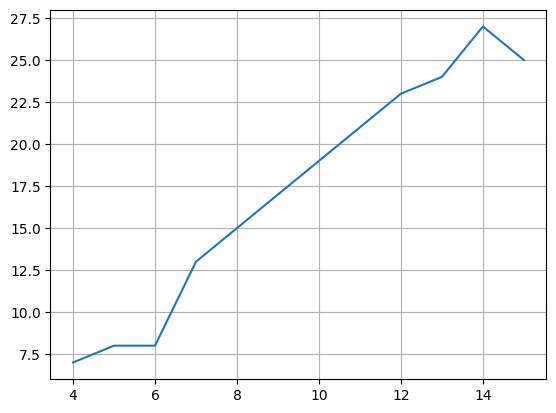

In [64]:
import matplotlib.pyplot as plt

plt.plot(nums, policy_iter)

plt.grid()

plt.show()

In [69]:
value_iters

[89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89]

In [70]:
policy_iter

[6,
 8,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 31,
 35,
 37,
 38,
 41,
 43,
 45,
 46]

In [67]:
len(policy_iter)

21

In [68]:
policy_time

[0.1890583038330078,
 0.44042181968688965,
 0.35162854194641113,
 0.4422125816345215,
 0.42902040481567383,
 0.3390920162200928,
 0.688941478729248,
 1.1454932689666748,
 0.7646441459655762,
 0.8901810646057129,
 1.0634267330169678,
 1.2749803066253662,
 1.822641134262085,
 3.5299253463745117,
 2.859572649002075,
 2.312700033187866,
 7.67841362953186,
 3.0791311264038086,
 6.858690500259399,
 4.742274522781372,
 8.730968713760376]